In [39]:
import os
import cv2
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.cuda.is_available()

True

## DataLoader

In [41]:

img_train = []
cnt = 0
train_path = './datasets/dataset/train'
for (root, dirs, files) in os.walk(train_path):
    for file in files:
        if file[-4:] != '.jpg':
            continue
        if file.split('_')[0] == "bad":
            cnt += 1
            if cnt > 40:
                continue
        img_train.append(os.path.join(root, file))
        
img_test = []

test_path = './datasets/dataset/test'
for (root, dirs, files) in os.walk(test_path):
    for file in files:
        if file[-4:] != '.jpg':
            continue
        img_test.append(os.path.join(root, file))

In [42]:
class LemonQualityDataset(Dataset):
    def __init__(self, img_paths, transform):
        super(LemonQualityDataset, self).__init__()
        self.img_paths = img_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        path = self.img_paths[idx]
        # image
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.asarray(image, dtype=np.uint8)
        image = Image.fromarray(image.astype(np.uint8))
        image = self.transform(image)

        # label
        label = 0 if path.split('/')[-2] == "bad" else 1
        return image.clone(), np.asarray(label, dtype=np.float32)

In [43]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]),
])


In [44]:
train_dataset = LemonQualityDataset(img_train, transform)
test_dataset = LemonQualityDataset(img_test, transform)

In [45]:

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle= True)

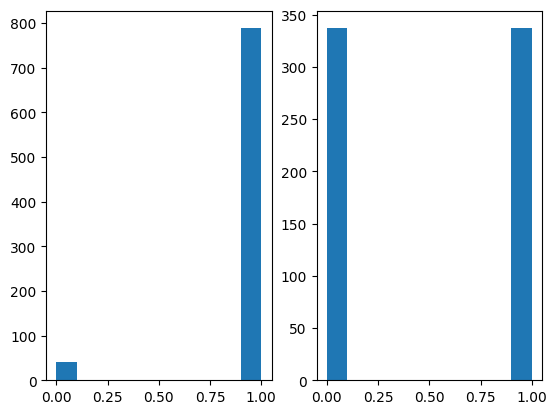

In [46]:
train_y = []
train_y_0 = 0
train_y_1 = 0
test_y_0 = 0
test_y_1 = 0
for x, y in train_loader:
    for t in y:
        if t == 1:
            train_y_1+=1
        else:
            train_y_0+=1
        train_y.append(int(t))
test_y = []
for x, y in test_loader:
    for t in y:
        if t == 1:
            test_y_1+=1
        else:
            test_y_0+=1
        test_y.append(int(t))

plt.subplot(1, 2, 1)
plt.hist(train_y)
plt.subplot(1, 2, 2)
plt.hist(test_y)
plt.show()


In [47]:
print(train_y_0)
print(train_y_1)
print(test_y_0)
print(test_y_1)

40
788
337
337


## Model

In [62]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 24, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(24, 36, 5)
        self.conv3 = nn.Conv2d(36, 12, 5)
        self.fc1 = nn.Linear(6912, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
        # self.bn1 = nn.BatchNorm1d(256)
        # self.bn2 = nn.BatchNorm1d(128)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        feat = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(feat, 1) 
        x = F.relu(self.fc1(x))
        score = F.relu(self.fc2(x))
        out = self.fc3(score)
        return torch.sigmoid(out), (score, feat)


net = Net().to(0)

In [63]:
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.0005)


## Training

In [64]:
net.train()
for epoch in range(10):
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        labels = labels.unsqueeze(1)
        inputs = inputs.to(0)
        labels = labels.to(0)
        optimizer.zero_grad()

        outputs, _ = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        print(f'Epoch : {epoch + 1} ({i}/{len(train_loader)}) loss: {loss.item():.5f}')
        running_loss = 0.0

print('Finished Training')

Epoch : 1 (0/7) loss: 0.70884
Epoch : 1 (1/7) loss: 0.37579
Epoch : 1 (2/7) loss: 0.37083
Epoch : 1 (3/7) loss: 0.40096
Epoch : 1 (4/7) loss: 0.09484
Epoch : 1 (5/7) loss: 0.22500
Epoch : 1 (6/7) loss: 0.20268
Epoch : 2 (0/7) loss: 0.18021
Epoch : 2 (1/7) loss: 0.10843
Epoch : 2 (2/7) loss: 0.14272
Epoch : 2 (3/7) loss: 0.15651
Epoch : 2 (4/7) loss: 0.19534
Epoch : 2 (5/7) loss: 0.35952
Epoch : 2 (6/7) loss: 0.20184
Epoch : 3 (0/7) loss: 0.21468
Epoch : 3 (1/7) loss: 0.20285
Epoch : 3 (2/7) loss: 0.22698
Epoch : 3 (3/7) loss: 0.16446
Epoch : 3 (4/7) loss: 0.23268
Epoch : 3 (5/7) loss: 0.20876
Epoch : 3 (6/7) loss: 0.02702
Epoch : 4 (0/7) loss: 0.22463
Epoch : 4 (1/7) loss: 0.16706
Epoch : 4 (2/7) loss: 0.18405
Epoch : 4 (3/7) loss: 0.07463
Epoch : 4 (4/7) loss: 0.11497
Epoch : 4 (5/7) loss: 0.24765
Epoch : 4 (6/7) loss: 0.21835
Epoch : 5 (0/7) loss: 0.17034
Epoch : 5 (1/7) loss: 0.16784
Epoch : 5 (2/7) loss: 0.13495
Epoch : 5 (3/7) loss: 0.03834
Epoch : 5 (4/7) loss: 0.17888
Epoch : 5 

## Evaluation

In [65]:
correct = 0
with torch.no_grad():
    net.eval()
    for x, y in test_loader:
        x = x.to(0)
        y = y.to(0)
        outputs,_ = net(x)
        out = outputs >= torch.FloatTensor([0.5]).to(0)
        correct+=sum(out.squeeze(1)==y)
        
print(correct/len(test_dataset)*100)


tensor(64.3917, device='cuda:0')


## Drawomg t-SNE

/home/vcl/anaconda3/envs/study/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/vcl/anaconda3/envs/study/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


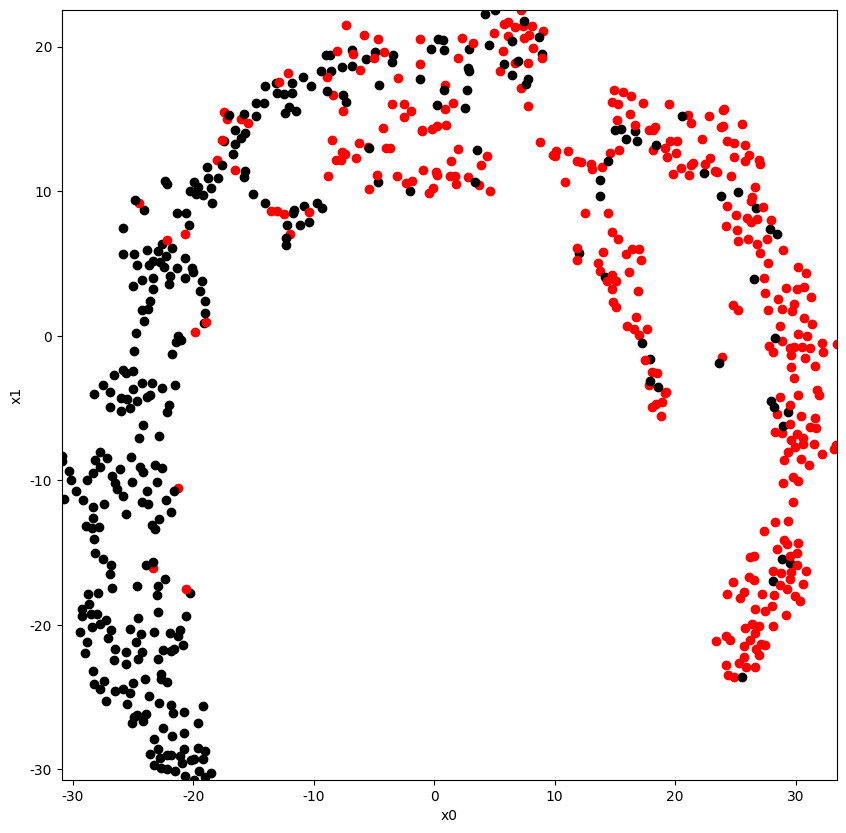

In [66]:

test = []
test_y = []
with torch.no_grad():
    net.eval()
    for x, y in test_loader:
        x = x.to(0)
        y = y.to(0)
        outputs,(score, feat) = net(x)
        score = score.to('cpu')
        for k in score:
            test.append(k)
        for k in y:
            test_y.append(k)


from sklearn.manifold import TSNE
plt.rc('axes', unicode_minus=False)
tsne = TSNE(n_components= 2, random_state = 20)
test = torch.stack(test, dim=0)
lemon_tsne = tsne.fit_transform(test)
plt.figure(figsize=(10,10))

color = ['k','red']
for i in range(len(test)):
        plt.scatter(lemon_tsne[i,0], lemon_tsne[i,1],
                color = color[int(test_y[i].item())],)

plt.xlim(lemon_tsne[:, 0].min(), lemon_tsne[:,0].max()) # 최소, 최대
plt.ylim(lemon_tsne[:, 1].min(), lemon_tsne[:,1].max()) # 최소, 최대
plt.xlabel("x0")
plt.ylabel("x1")
plt.show()